## Spike inference with Cascade

### Cloning the repository of the CASCADE software

### Importing packages and CASCADE

In [2]:
#@markdown Downloads packages from public repository, and packages from Cascade.
# standard python packages
import os
os.chdir('Cascade')
import os, warnings
import glob
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import ruamel.yaml as yaml
yaml = yaml.YAML(typ='rt')

# cascade2p packages, imported from the downloaded Github repository
from cascade2p import checks
checks.check_packages()
from cascade2p import cascade # local folder
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

	YAML reader installed (version 0.18.6).


2024-07-29 13:25:20.332790: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-29 13:25:20.487293: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-29 13:25:20.769450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 13:25:21.023781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 13:25:21.108273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 13:25:21.489363: I tensorflow/core/platform/cpu_feature_gu

	Keras installed (version 3.4.1).
	Tensorflow installed (version 2.17.0).


/home/zenn/anaconda3/envs/VCS/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### Definition of the function used to load the zscore traces

In [3]:
#@markdown ΔF/F traces must be saved as \*.npy-files (for Python) or \*.mat-files (for Matlab/Python) as a single large matrix named **`dF_traces`** (neurons x time). ΔF/F values of the input should be numeric, not in percent (e.g. 0.5 instead of 50%). For different input formats, the code in this box can be modified (it\'s not difficult).

def load_neurons_x_time(file_path):
    """Custom method to load data as 2d array with shape (neurons, nr_timepoints)"""

    if file_path.endswith('.mat'):
      traces = sio.loadmat(file_path)['dF_traces']

    elif file_path.endswith('.npy'):
      traces = np.load(file_path, allow_pickle=True)
      # if saved data was a dictionary packed into a numpy array (MATLAB style): unpack
      if traces.shape == ():
        traces = traces.item()['dF_traces']

    else:
      raise Exception('This function only supports .mat or .npy files.')

    print('Traces standard deviation:', np.nanmean(np.nanstd(traces,axis=1)))
    if np.nanmedian(np.nanstd(traces,axis=1)) > 2:
      print('Fluctuations in dF/F are very large, probably dF/F is given in percent. Traces are divided by 100.')
      return traces/100
    else:
        return traces

### Saving the files in npy to use CASCADE

In [ ]:
#path to data
folder_tracce = '../placeholder/'
folder_to_save = '../placeholder/'

#Hyperparameters of experimental data
f_sam = 30 #Hz   #sampling frequence
dt = 1/f_sam*10**(3) #ms   #sampling interval

#gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 6

#percentage to keep
top_percentange = 0.8

#### Run only once to convert data from npz to npy

In [5]:
#listing the files in the folders
files_tracce = os.listdir(folder_tracce)

#zipping together the correspondent traces and stimuli
file_list = []
for f in files_tracce:

    #loading the data
    data = np.load(folder_tracce+f)
    traces = data['zscored_full']

    #filtering by snr
    filtered_snr = data['filtered_snr']
    idx = np.argsort(filtered_snr)

    #keeping the top 30%
    idx = idx[:int(top_percentange*len(idx))]

    #masking
    traces = traces[idx,:]

    smoothed_trace = np.zeros(traces.shape)

    for n in range(traces.shape[0]):
        smoothed_trace[n, :] =gaussian_filter1d(traces[n, :], sigma)
        
    #extracting the stimuli pattern
    pattern = f.split('.npz')[0]
    #saving them as npy
    np.save(folder_to_save+pattern,smoothed_trace)

### Selecting the pretrained model

In [5]:
#@markdown Get list of the names of available models.

cascade.download_model('update_models',verbose = 1)

yaml_file = open('Pretrained_models/available_models.yaml')
X = yaml.load(yaml_file)
list_of_models = list(X.keys())
print('\n List of available models: \n')
for model in list_of_models:
  print(model)

You can now check the updated available_models.yaml file for valid model names.
File location: /media/zenn/6535-3462/neural_data_analysis/Cascade/Pretrained_models/available_models.yaml

 List of available models: 

Global_EXC_1Hz_smoothing500ms
Global_EXC_1Hz_smoothing1000ms
Zebrafish_1Hz_smoothing1000ms
Global_EXC_2Hz_smoothing300ms
Global_EXC_2Hz_smoothing500ms
Global_EXC_2Hz_smoothing1000ms
Global_EXC_2.5Hz_smoothing400ms_high_noise
Global_EXC_3Hz_smoothing400ms
Global_EXC_3Hz_smoothing400ms_high_noise
Global_EXC_3Hz_smoothing400ms_causalkernel
Global_EXC_4.25Hz_smoothing300ms
Global_EXC_4.25Hz_smoothing300ms_high_noise
Global_EXC_4.25Hz_smoothing300ms_causalkernel
Global_EXC_5Hz_smoothing200ms
Global_EXC_5Hz_smoothing200ms_causalkernel
Global_EXC_6Hz_smoothing200ms
Global_EXC_6Hz_smoothing200ms_causalkernel
Global_EXC_7Hz_smoothing200ms
Global_EXC_7Hz_smoothing200ms_causalkernel
Global_EXC_7.5Hz_smoothing200ms_high_noise
Global_EXC_7.5Hz_smoothing200ms
Global_EXC_7.5Hz_smoothing20

#### Selecting a model trained on data at 30 Hz of sampling frequency

In [6]:
#@markdown Select (from the list above) and download the model that fits to your dataset (frame rate, training data; see FAQ for more details) and assign to variable **`model_name`**.
model_name = 'Global_EXC_30Hz_smoothing200ms_causalkernel_high_noise'

cascade.download_model( model_name,verbose = 1)

Pretrained model was saved in folder "/media/zenn/6535-3462/neural_data_analysis/Cascade/Pretrained_models/Global_EXC_30Hz_smoothing200ms_causalkernel_high_noise"


### Selecting folder with dF/F traces in npy and listing the files

In [7]:
folder = '../placeholder'
files = os.listdir(folder) 
files.sort()
file = files[0]

### Infer the spikes with CASCADE

In [8]:
folder_to_save = '../results/inferred_spikes/'

In [10]:
for kk, file in enumerate(files):

    print('Processing file:', file, '(', kk+1, '/', len(files), ')')

    ### LOAD DATA

    #@markdown If you are testing the script, you can leave everything unchanged. If you want to apply the algorithm to your own data, you have to upload your data first. The paragraph above tells you how to format and name the file. You can do this by clicking on the **folder symbol ("Files")** on the left side of the Colaboratory notebook. Next, indicate the path of the uploaded file in the variable **`example_file`**. Finally, indicate the sampling rate of your recordings in the variable **`frame_rate`**.

    example_file = folder + file #"Example_datasets/Allen-Brain-Observatory-Visual-Coding-30Hz/Experiment_552195520_excerpt.mat" #@param {type:"string"}

    frame_rate = 30 #@param {type:"number"}

    try:

        traces = load_neurons_x_time( example_file )
        print('Number of neurons in dataset:', traces.shape[0])
        print('Number of timepoints in dataset:', traces.shape[1])

    except Exception as e:

        print('\nSomething went wrong!\nEither the target file is missing, in this case please provide the correct location.\nOr your file is not yet completely uploaded, in this case wait until the upload is completed.\n')

        print('Error message: '+str(e))


    #INFERE SPIKES
    #@markdown If this takes too long, make sure that the GPU runtime is activated (*Menu > Runtime > Change Runtime Type*).

    total_array_size = traces.itemsize*traces.size*64/1e9

    # If the expected array size is too large for the Colab Notebook, split up for processing


    print("Split analysis into chunks in order to fit into Colab memory.")

    # pre-allocate array for results
    spike_prob = np.zeros((traces.shape))
    # nb of neurons and nb of chuncks
    nb_neurons = traces.shape[0]
    nb_chunks = int(np.ceil(total_array_size/10))

    chunks = np.array_split(range(nb_neurons), nb_chunks)
    # infer spike rates independently for each chunk
    for part_array in range(nb_chunks):
        spike_prob[chunks[part_array],:] = cascade.predict( model_name, traces[chunks[part_array],:] )

    ## SETTING NAN generated by the network to 0
    np.nan_to_num(spike_prob, 0) 


    ## SAVE INFERRED SPIKES

    #@markdown By default saves as variable **`spike_prob`** both to a *.mat-file and a *.npy-file. You can uncomment the file format that you do not need or leave it as it is.
    file_name = 'predictions_' + os.path.splitext( os.path.basename(example_file))[0]
    save_path = os.path.join(folder_to_save, file_name)

    # save as numpy file
    np.save(save_path, spike_prob)


Processing file: filtered_traces_20220404-wt-GCaMP6s-stim mix-okdx-filed2-stim1.npy ( 1 / 8 )
Traces standard deviation: 0.9130105354678923
Number of neurons in dataset: 90
Number of timepoints in dataset: 45000
Split analysis into chunks in order to fit into Colab memory.

 
The selected model was trained on 18 datasets, with 5 ensembles for each noise level, at a sampling rate of 30Hz, with a resampled ground truth that was smoothed with a causal kernel of a standard deviation of 200 milliseconds. 
 

Loaded model was trained at frame rate 30 Hz
Given argument traces contains 90 neurons and 45000 frames.


Noise levels (mean, std; in standard units): 0.41, 0.09

Predictions for noise level 2:


/home/zenn/anaconda3/envs/VCS/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


	... ensemble 0


## Analysis of inferred spikes from zscores

In [1]:
# Libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
plt.style.use('tableau-colorblind10')
from scipy.signal import welch

In [34]:
#settings for plots

#tableau for plots
plt.style.use('tableau-colorblind10')

plt.rcParams["figure.autolayout"] = True

plt.rcParams['font.size'] = 16        # Default font size for text
plt.rcParams['axes.titlesize'] = 16   # Font size for axes titles
plt.rcParams['axes.labelsize'] = 16   # Font size for x and y labels
plt.rcParams['xtick.labelsize'] = 16  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 16  # Font size for y tick labels

In [2]:
# Hyperparameters
f_sam = 30 #Hz
dt = 1/f_sam*10**3 #ms

### Plot of some zscore and comparison with the corresponding rate

In [5]:
import os
os.chdir('Cascade')

path_zscore = '../placeholder/'
path_rate = '../placeholder'

In [6]:
files_zscore = os.listdir(path_zscore)
files_spikes = os.listdir(path_rate)

files_zscore.sort()
files_spikes.sort()

In [7]:
file_samples = np.random.randint(0,len(files_zscore),4)
n_trace_samples = np.random.randint(0, 10, 4)

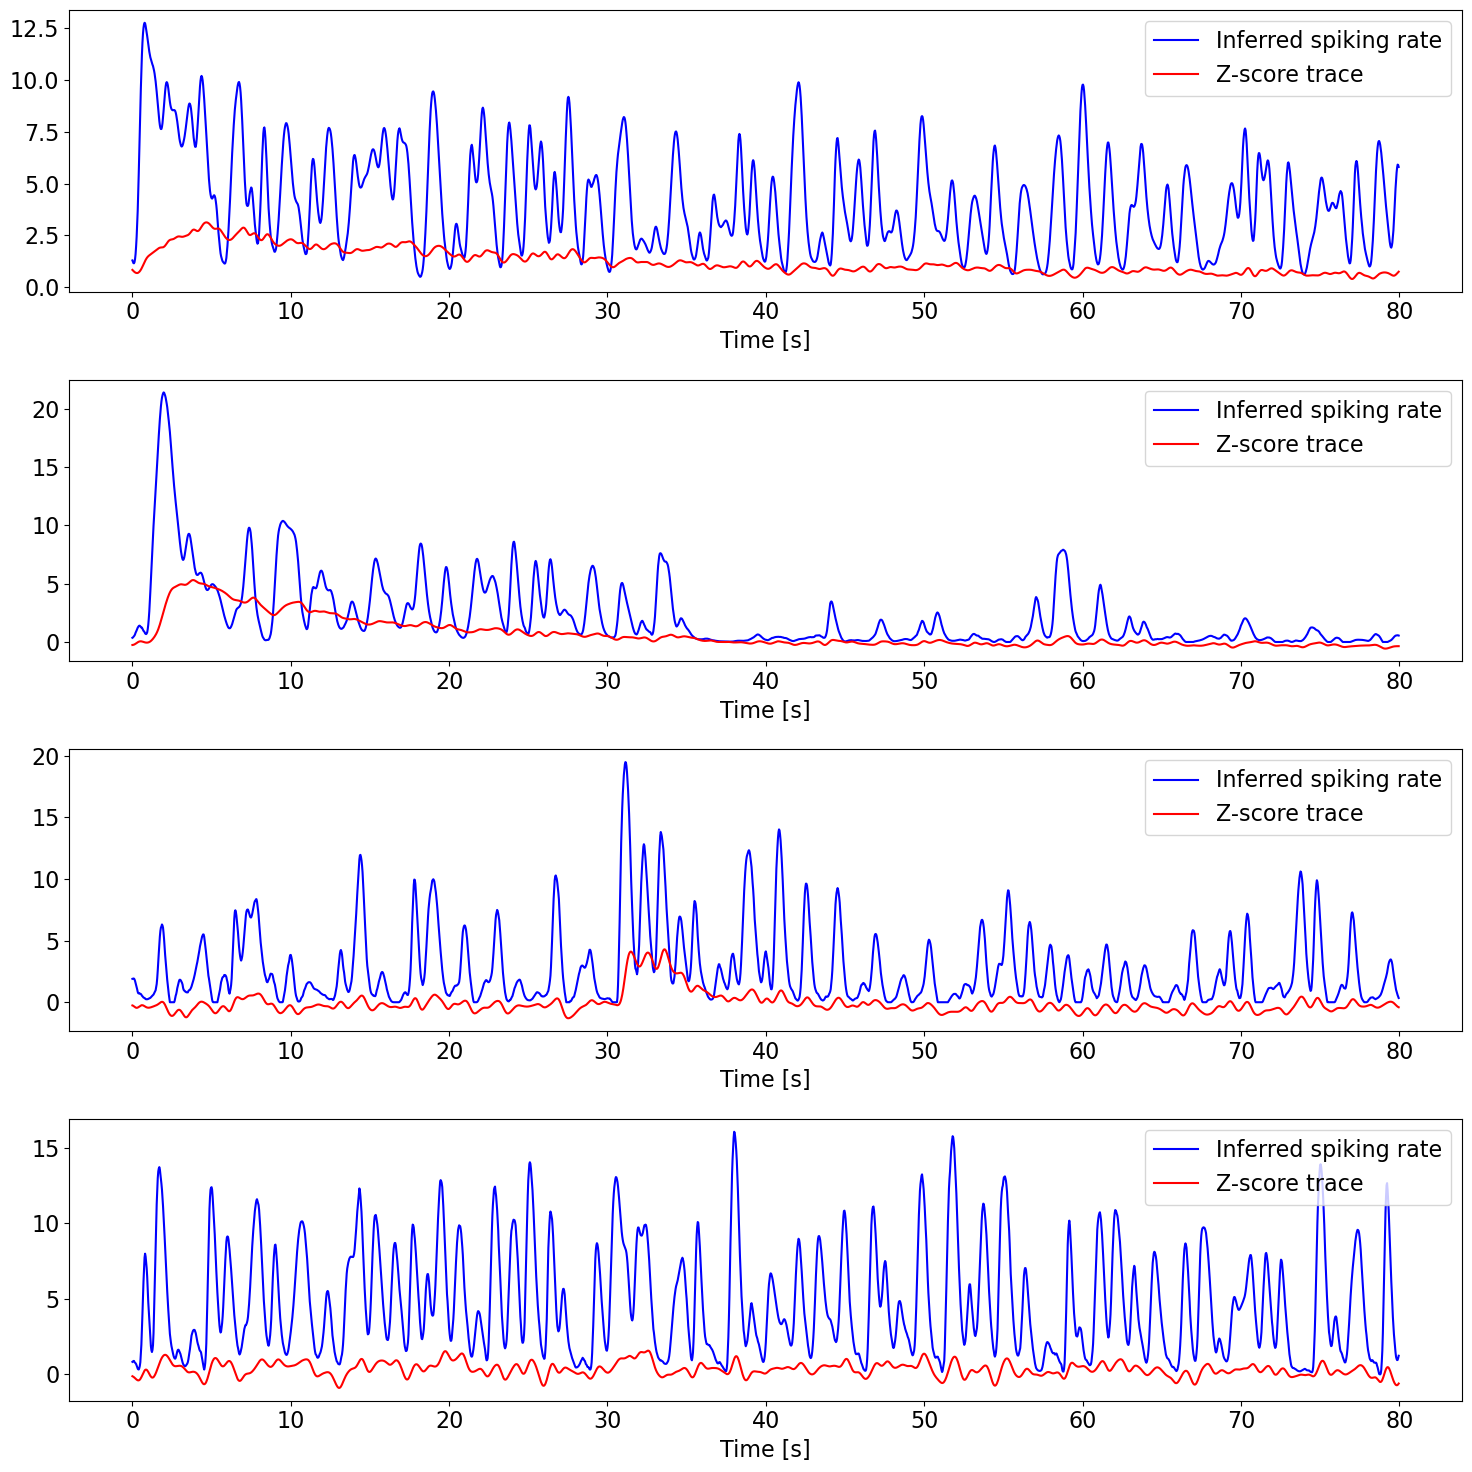

In [37]:
fig, ax = plt.subplots(4,1, figsize = (15,15))
counter = 0

for kk, jj in zip(file_samples, n_trace_samples):
 
    filez = files_zscore[kk]
    files = files_spikes[kk]

    j = np.random.randint(1, 10)
    time_window = np.arange(5400 + j*2700, 5400 + j*2700 + 2400)

    rates = np.load(path_rate+files)*f_sam
    traces = np.load(path_zscore+filez)

    ax[counter].plot(np.arange(len(time_window))*dt*10**(-3), rates[jj,time_window],color = 'blue', label = 'Inferred spiking rate')
    ax[counter].plot(np.arange(len(time_window))*dt*10**(-3),  traces[jj,time_window], color = 'red', label = 'Z-score trace')

    ax[counter].set_xlabel('Time [s]')
    ax[counter].legend()

    counter =counter+1

plt.savefig('../results/inferred_spikes/inferred_spikes.png', pad_inches = 0.1, bbox_inches = 'tight')

## Saving the rates in a single npy file

In [10]:
rates = []
for filez in files_spikes:
    rate = np.load(path_rate+filez)*f_sam
    rates.append(rate)

In [11]:
rates = np.concatenate(rates, axis = 0)
print(rates.shape)
np.save('../data/rates/inferred_rates.npy', rates)

(167, 45000)


## Analysis of inferred spikes

In [38]:
rates = np.load('../data/rates/inferred_rates.npy')

### Autocorrelation function

In [39]:
#Half-Width at Half-Maximum Estimator
def HWHM(C):
    half = 0.5
    idx = np.argmin(np.abs(C - half))

    return idx

In [40]:
#hyperparameters
n_lags = 90*f_sam

p = 0.01

In [41]:
average_C = np.zeros(n_lags+1)
taus = []

for j,rate in enumerate(rates):

    # Compute the autocorrelation function for a range of lags
    C = sm.tsa.acf(rate, nlags=n_lags)
    taus.append(HWHM(C))

    average_C = average_C + C

    if np.random.random() < p:
        plt.figure(figsize=(12, 6))
        plt.plot(C, color = 'blue')
        plt.axvline(x=taus[-1], color = 'black', linestyle = '--', label = 'Autocorrelation HW')
        plt.legend()
        plt.xlabel('Lag (frames)')
        plt.ylabel('Autocorrelation of rates')
        plt.savefig('../results/inferred_spikes/acf_examples/example{}.png'.format(j))   
        plt.close()
        

average_C = average_C/rates.shape[0]

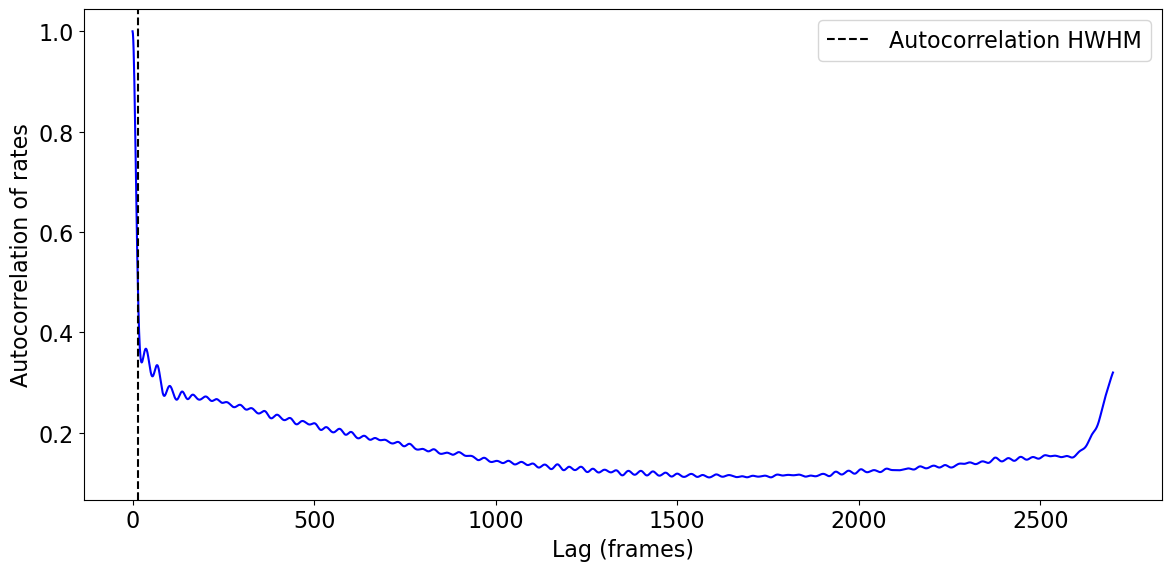

In [42]:
## Plot of autocorrelation function
plt.figure(figsize=(12, 6))
plt.plot(average_C, color = 'blue')
plt.axvline(x=HWHM(average_C), color = 'black', linestyle = '--', label = 'Autocorrelation HWHM')
plt.legend()
plt.xlabel('Lag (frames)')
plt.ylabel('Autocorrelation of rates')
plt.savefig('../results/inferred_spikes/acf_examples/average_acf.png')
plt.show()

### Autocorrelation times distribution

In [43]:
taus = np.array(taus)*dt

taus = taus[taus<90_000]

In [44]:
bin_edges = np.linspace(0, 10, 22)*5*dt

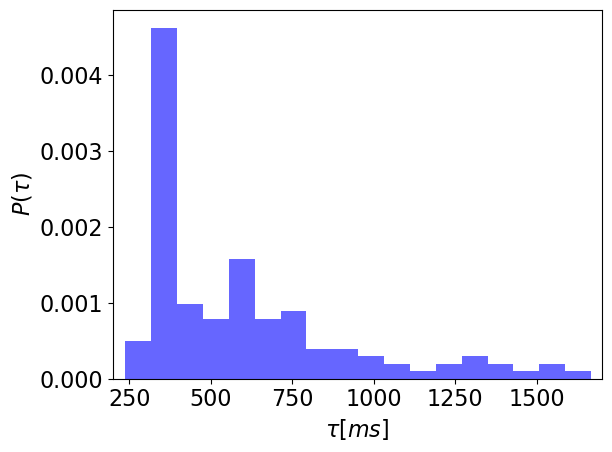

In [45]:
plt.hist(taus, bins = bin_edges, color = 'blue', density=True, alpha = 0.6)
plt.xlabel(r'$\tau [ms]$')
plt.ylabel(r'$P(\tau)$')
plt.xlim([200, 1700])
plt.savefig('../results/inferred_spikes/tau_distribution.png')
plt.show()

### Power spectrum

In [46]:
length = rates.shape[1]

In [47]:
#Computing the average spectral density
avg_P = np.zeros(length//2 +1)
avg_w = np.zeros(length//2 +1)

for rate in rates:
    
    omega, psd = welch(rate, fs = 30, noverlap=1, nperseg = length)    
    avg_P = avg_P + psd
    avg_w = omega + avg_w

avg_P = avg_P/rates.shape[0]
avg_w = avg_w/rates.shape[0]

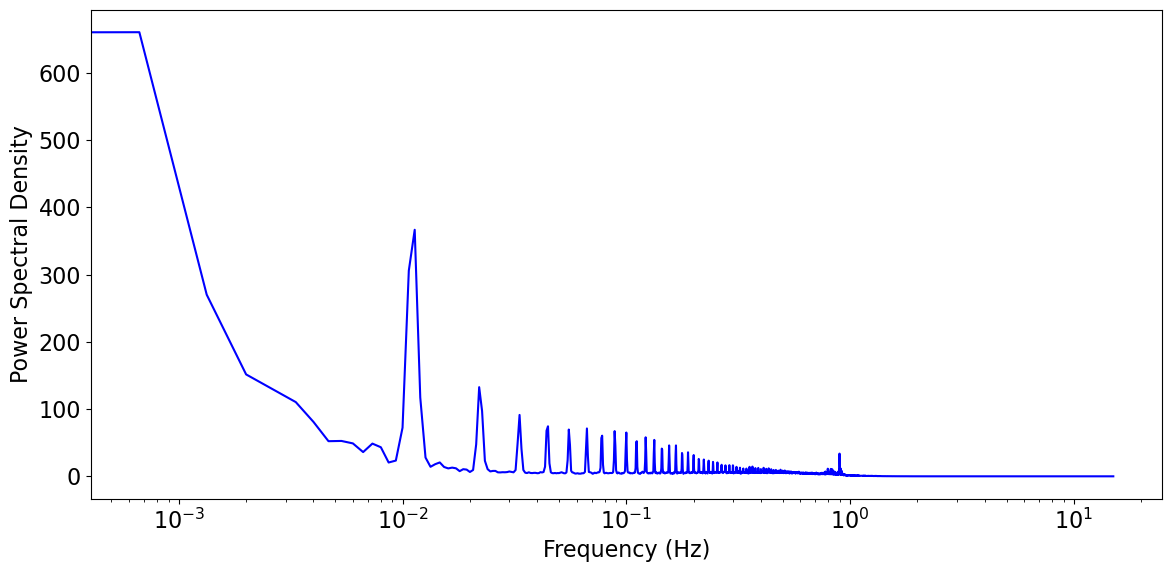

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(avg_w, avg_P, color = 'blue')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.savefig('../results/inferred_spikes/psd.png')